In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [4]:
!pip install wandb --upgrade
wandb.login()

SyntaxError: invalid syntax (3401911853.py, line 2)

# Getting Started Competition

In [17]:
import torch
import numpy as np
import pandas as pd
import spacy
from torch.utils.data import Dataset
from transformers import EvalPrediction, Trainer, TrainingArguments, DistilBertTokenizerFast
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Load the tokenizer
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

%env WANDB_PROJECT=twitter_disaster_analysis

### Logging with Accelerate

In [ ]:
from accelerate import Accelerator

# Tell the Accelerator object to log with wandb
accelerator = Accelerator(log_with="wandb")

# Initialise your wandb run, passing wandb parameters and any config information
accelerator.init_trackers(
    project_name="my_project", 
    config={"dropout": 0.1, "learning_rate": 1e-2}
    init_kwargs={"wandb": {"entity": "my-wandb-team"}}
    )

...

# Log to wandb by calling `accelerator.log`, `step` is optional
accelerator.log({"train_loss": 1.12, "valid_loss": 0.8}, step=global_step)


# Make sure that the wandb tracker finishes correctly
accelerator.end_training()

## Notebook Setup

The first thing we need to do is setup our notebook and clean the data.

1. So we load the data into pandas
2. Check the first few rows of our data
3. Then we drop rows with n/a data

In [18]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = self.preprocess_text(texts)
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        # Check if we have labels
        if self.labels is not None:
            label = self.labels[idx]
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(label, dtype=torch.long),
            }
        else:  # Return only inputs for test data
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
            }


    def preprocess_text(self, texts):
        preprocessed_texts = []
        for text in texts:
            # Apply SpaCy pipeline on the text
            doc = nlp(text)
            # Lemmatize the text and join the words back into a single string
            lemma_text = " ".join([token.lemma_ for token in doc])
            preprocessed_texts.append(lemma_text)
        return preprocessed_texts


def compute_metrics(eval_pred: EvalPrediction):
    labels = eval_pred.label_ids
    preds = np.argmax(eval_pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


## Load The Data

In [19]:
# Handle missing values by filling with a placeholder value
train_df = train_df.fillna('None')
test_df = test_df.fillna('None')
# Combine train and test data
combined_df = pd.concat([train_df, test_df])

# One-hot encode the 'keyword' field
combined_df = pd.get_dummies(combined_df, columns=['keyword'])
# Split back into train and test data
train_df = combined_df[:len(train_df)]
test_df = combined_df[len(train_df):]

train_df = train_df.copy()
test_df = test_df.copy()

train_df.loc[:, 'input'] = train_df.apply(lambda row: f"{row['text']}", axis=1)
test_df.loc[:, 'input'] = test_df.apply(lambda row: f"{row['text']}", axis=1)

# Extract 'input' as input and 'target' as labels from the train data
train_texts = train_df['input'].tolist()
train_labels = train_df['target'].tolist()
# For the test data, we only need the 'input' column
test_texts = test_df['input'].tolist()


# Split the train data into train and validation subsets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2)

# Print the sizes of the training and validation subsets
print(f"Training set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")

Training set size: 6090
Validation set size: 1523


## Initialize the datasets

In [20]:
train_dataset = TweetDataset(train_texts, train_labels, tokenizer)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer)
test_dataset = TweetDataset(test_texts, None, tokenizer)  # No labels for the test data

## Load bert

In [21]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2, hidden_dropout_prob=0.3)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.

### Split the data into training and validation sets

In [22]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=1e-5)

In [23]:
from transformers import Trainer, TrainingArguments

# Define the training arguments
training_args = TrainingArguments(
    report_to="wandb",
    run_name="distilbert",
    load_best_model_at_end=True,
    output_dir='../models/results',
    num_train_epochs=3,
    evaluation_strategy='epoch',  # evaluation is performed at the end of each epoch
    fp16=True
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                     # the instantiated Transformers model to be trained
    args=training_args,              # training arguments, defined above
    train_dataset=train_dataset,     # training dataset
    eval_dataset=val_dataset,        # evaluation dataset
    compute_metrics=compute_metrics  # function to compute metrics
)

# Train the model
trainer.train()


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.483300,0.424424,0.827971,0.768959,0.910230,0.665649
2,0.344300,0.511259,0.839790,0.806656,0.838550,0.777099
3,0.239500,0.594052,0.835850,0.803150,0.829268,0.778626


TrainOutput(global_step=2286, training_loss=0.3458127132759528, metrics={'train_runtime': 1169.2502, 'train_samples_per_second': 15.625, 'train_steps_per_second': 1.955, 'total_flos': 2420179373445120.0, 'train_loss': 0.3458127132759528, 'epoch': 3.0})

### Plot confusion matrix

In [25]:
# Get predictions
predictions = trainer.predict(train_dataset)

# The predictions are in a tuple with the loss, we only need the actual predictions
train_preds = np.argmax(predictions.predictions, axis=1)


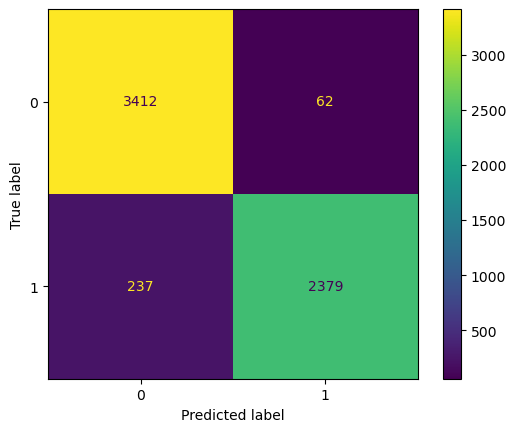

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
conf_matrix = confusion_matrix(train_labels, train_preds, labels=[0, 1])

# Create the plot
myplt = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
myplt.plot()

# Show the plot
plt.show()


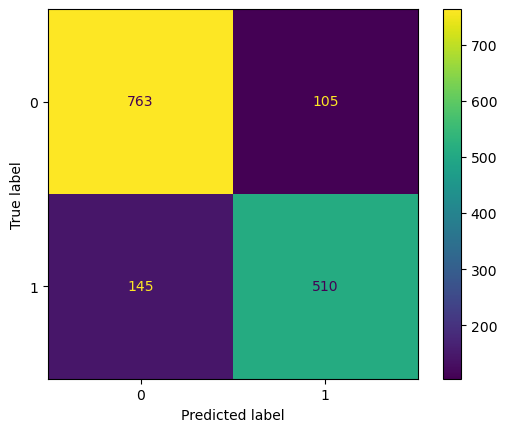

In [28]:
# Get predictions
predictions = trainer.predict(val_dataset)

# The predictions are in a tuple with the loss, we only need the actual predictions
val_preds = np.argmax(predictions.predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(val_labels, val_preds, labels=[0, 1])

# Create the plot
myplt = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
myplt.plot()

# Show the plot
plt.show()


### Submission Output to CSV file


In [30]:
# Save the model
trainer.save_model("/kaggle/working/models")

poch	Training Loss	Validation Loss	Accuracy	F1	Precision	Recall
1		0.440484	0.820749	0.802603	0.786119	0.819793
2		0.535762	0.829284	0.800919	0.831479	0.772526
3		0.677442	0.824032	0.795732	0.822047	0.771049

### 4. **Loss Curve**

If you stored the loss at each epoch during training, you can plot it to see how the model improved over time.


In [ ]:
training_loss = [0.473400,0.329400,0.239600]

plt.plot(training_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Make Test Predictions

In [29]:
# Making predictions on test data
test_predictions = trainer.predict(test_dataset)

# We take the output class with the highest probability
test_preds = np.argmax(test_predictions.predictions, axis=1)

# Prepare a DataFrame with test IDs and predictions
submission_df = pd.DataFrame({
    'id': test_df['id'],  # Assuming that 'test_df' is the DataFrame with your test data
    'target': test_preds
})

wandb.finish()

In [ ]:
# Save the DataFrame into a CSV file
submission_df.to_csv('submission.csv', index=False)